# 1. Hurricane Track Prediction & Clustering

### 1. Overview
This project aims to analyze how ENSO (El Niño/La Niña) influences both the frequency and track movement of hurricanes in the North Atlantic (NA) region. Using machine learning techniques, we examine the relationship between ENSO phases and hurricane trajectories.

Dataset
- IBTrACS (North Atlantic): Contains historical hurricane data (location, intensity, speed, direction, etc.).
- NOAA SOI Data: Used to classify ENSO phases (El Niño, La Niña, Neutral).

### 2. Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import requests
from io import StringIO

### 3. Loading and Processing SOI Data

In [3]:
import requests
import pandas as pd
from io import StringIO

def process_soi_data(url):
    """
    Fetch and process SOI data from NOAA website.
    Fixes invalid year formatting and converts monthly SOI into annual averages.
    """
    # Fetch data
    response = requests.get(url)
    raw_text = response.text.split("\n")

    # Locate first "YEAR" occurrence (start of Anomaly table)
    start_index = next(i for i, line in enumerate(raw_text) if "YEAR" in line)
    end_index = next(i for i, line in enumerate(raw_text[start_index+1:], start_index+1) if "YEAR" in line)

    # Extract only the first table (Anomaly data)
    raw_data = raw_text[start_index:end_index]

    # Convert text into pandas DataFrame
    cleaned_data = "\n".join(raw_data)
    df = pd.read_csv(StringIO(cleaned_data), sep='\\s+', engine='python', dtype=str)  # Load everything as string first

    # Ensure correct column names
    df.columns = ["Year", "Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

    # Fix issue: Extract only first four characters from "Year"
    df["Year"] = df["Year"].astype(str).str[:4]  # Keep only valid 4-digit years
    df = df[df["Year"].str.isnumeric()]  # Ensure all values are numeric
    df["Year"] = df["Year"].astype(int)  # Convert to integer

    # Remove invalid future years (keep only data up to 2024)
    df = df[df["Year"] <= 2024]

    # Convert SOI values from string to float
    for col in df.columns[1:]:
        df[col] = pd.to_numeric(df[col], errors="coerce")  # Convert to float, set invalids to NaN

    # Compute annual SOI mean
    df["SOI_Annual"] = df.iloc[:, 1:].mean(axis=1, skipna=True)

    # Compute seasonal SOI mean (June to November)
    df["SOI_Hurricane_Season"] = df[["Jun", "Jul", "Aug", "Sep", "Oct", "Nov"]].mean(axis=1, skipna=True)

    # Select only Year, SOI_Annual, and SOI_Hurricane_Season columns
    df = df[["Year", "SOI_Annual", "SOI_Hurricane_Season"]]

    return df

# Load and process SOI data
soi_url = "https://www.cpc.ncep.noaa.gov/data/indices/soi"
soi_data = process_soi_data(soi_url)

# Verify output
print(soi_data.head())
print(soi_data.dtypes)  # Ensure all columns have correct data types


   Year  SOI_Annual  SOI_Hurricane_Season
0  1951   -0.458333             -1.083333
1  1952   -0.041667              0.383333
2  1953   -0.683333             -0.716667
3  1954    0.733333              0.600000
4  1955    1.691667              2.316667
Year                      int64
SOI_Annual              float64
SOI_Hurricane_Season    float64
dtype: object


In [4]:
print(soi_data.tail())

    Year  SOI_Annual  SOI_Hurricane_Season
69  2020    0.775000              0.883333
70  2021    1.525000              1.350000
71  2022    2.166667              1.966667
72  2023   -0.200000             -0.933333
73  2024    0.275000              0.300000


### 4. Comparing Annual vs. Seasonal SOI for Hurricane Prediction

In [5]:
# Load NetCDF hurricane dataset
file_path = "NA_data.nc"  # Update with actual path
ds = xr.open_dataset(file_path)

# Extract hurricane season data (hurricane occurrence per year)
season = ds["season"].values  # Extract hurricane year

# Create hurricane counts DataFrame
hurricane_data = pd.DataFrame({"Year": season})
hurricane_counts = hurricane_data.groupby("Year").size().reset_index(name="Hurricane_Count")

# Ensure Year column is integer type in both datasets
hurricane_counts["Year"] = hurricane_counts["Year"].astype(int)
soi_data["Year"] = soi_data["Year"].astype(int)

# Filter hurricane data to only include years where SOI data exists
hurricane_counts = hurricane_counts[hurricane_counts["Year"].isin(soi_data["Year"])]

# Merge hurricane count data with SOI data
enso_hurricane_data = pd.merge(hurricane_counts, soi_data, on="Year", how="left")

# Verify merged dataset
print(enso_hurricane_data.head())
print(enso_hurricane_data.isna().sum())  # Check if NaNs are still present


   Year  Hurricane_Count  SOI_Annual  SOI_Hurricane_Season
0  1951               12   -0.458333             -1.083333
1  1952               11   -0.041667              0.383333
2  1953               14   -0.683333             -0.716667
3  1954               16    0.733333              0.600000
4  1955               13    1.691667              2.316667
Year                    0
Hurricane_Count         0
SOI_Annual              0
SOI_Hurricane_Season    0
dtype: int64


In [6]:
#Compare Model Performance Using Annual vs. Seasonal SOI
# Train Model Using Annual SOI
X_annual = enso_hurricane_data[["SOI_Annual"]].values
y = enso_hurricane_data["Hurricane_Count"].values

X_train, X_test, y_train, y_test = train_test_split(X_annual, y, test_size=0.2, random_state=42)
xgb_model_annual = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model_annual.fit(X_train, y_train)

y_pred_annual = xgb_model_annual.predict(X_test)
mse_annual = mean_squared_error(y_test, y_pred_annual)
print(f"Mean Squared Error (Annual SOI): {mse_annual}")

# Train Model Using Seasonal SOI
X_seasonal = enso_hurricane_data[["SOI_Hurricane_Season"]].values

X_train, X_test, y_train, y_test = train_test_split(X_seasonal, y, test_size=0.2, random_state=42)
xgb_model_seasonal = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, max_depth=5, learning_rate=0.1)
xgb_model_seasonal.fit(X_train, y_train)

y_pred_seasonal = xgb_model_seasonal.predict(X_test)
mse_seasonal = mean_squared_error(y_test, y_pred_seasonal)
print(f"Mean Squared Error (Seasonal SOI): {mse_seasonal}")

Mean Squared Error (Annual SOI): 90.98640877139994
Mean Squared Error (Seasonal SOI): 55.8205139722512


In [7]:
correlation_annual = enso_hurricane_data["SOI_Annual"].corr(enso_hurricane_data["Hurricane_Count"])
correlation_seasonal = enso_hurricane_data["SOI_Hurricane_Season"].corr(enso_hurricane_data["Hurricane_Count"])

print(f"Correlation (Annual SOI vs. Hurricanes): {correlation_annual}")
print(f"Correlation (Seasonal SOI vs. Hurricanes): {correlation_seasonal}")

Correlation (Annual SOI vs. Hurricanes): 0.3228142200308332
Correlation (Seasonal SOI vs. Hurricanes): 0.35253970397360146


### 5. Refining the Hurricane Prediction Model

Now that we are using SOI_Hurricane_Season, we improve our hurricane count prediction model.
Use hyperparameter tuning to improve model accuracy.

In [8]:
from sklearn.model_selection import RandomizedSearchCV

# Define the feature and target variable
X_final = enso_hurricane_data[["SOI_Hurricane_Season"]].values
y = enso_hurricane_data["Hurricane_Count"].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Define model
xgb_model_final = xgb.XGBRegressor(objective="reg:squarederror")

# Define hyperparameter search space
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'min_child_weight': [1, 3, 5, 7]
}

# Perform hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model_final,
    param_distributions=param_grid, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_squared_error', 
    verbose=1, 
    random_state=42
)
random_search.fit(X_train, y_train)

# Best model
best_xgb_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)

# Evaluate best model
y_pred_final = best_xgb_model.predict(X_test)
mse_final = mean_squared_error(y_test, y_pred_final)
print(f"Final Model Mean Squared Error: {mse_final}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 50, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.7}
Final Model Mean Squared Error: 41.37834052602066


### 6. Clustering Hurricanes Based on Tracks

Use K-Means clustering to group hurricanes based on their latitude and longitude.
Identify track patterns and potential links to ENSO phases.

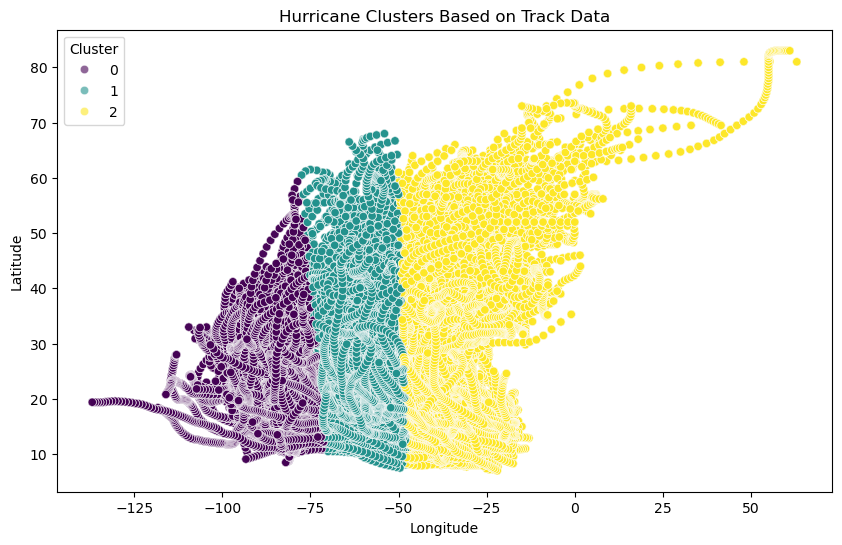

In [11]:
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Convert NetCDF dataset to DataFrame
storm_data = ds.to_dataframe().reset_index()

# Extract only rows with valid lat/lon for clustering
X_tracks = storm_data[["lat", "lon"]].dropna()

# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_tracks)

# Create a new DataFrame that includes clustering results
clustered_storms = X_tracks.copy()
clustered_storms["Cluster"] = kmeans.labels_

# Merge back the clustered data with storm_data (optional, if needed for full dataset)
storm_data = storm_data.merge(clustered_storms, on=["lat", "lon"], how="left")

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=clustered_storms, x="lon", y="lat", hue="Cluster", palette="viridis", alpha=0.6)
plt.title("Hurricane Clusters Based on Track Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


### 7.Linking Clusters with ENSO Phases

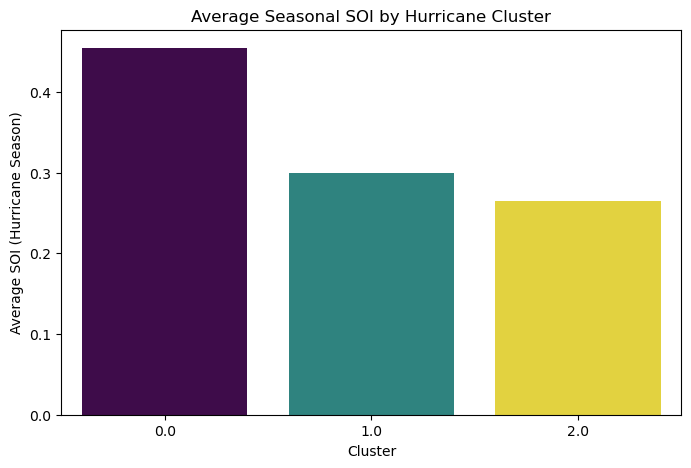

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(
    data=enso_cluster_analysis,
    x="Cluster",
    y="SOI_Hurricane_Season",
    hue="Cluster",  # Add hue to resolve FutureWarning
    palette="viridis",
    legend=False  # Hide redundant legend
)
plt.title("Average Seasonal SOI by Hurricane Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average SOI (Hurricane Season)")
plt.show()

### 8. ENSO Phase Distribution by Cluster

<Figure size 800x500 with 0 Axes>

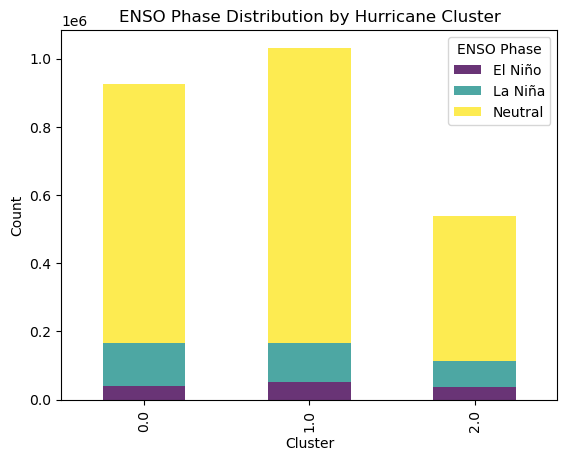

In [22]:
# Redefine ENSO Phase based on SOI values (If SOI >= +1, La Niña. If SOI <= -1, El Niño)
storm_data["ENSO_Phase"] = storm_data["SOI_Hurricane_Season"].apply(
    lambda x: "La Niña" if x >= 1 else ("El Niño" if x <= -1 else "Neutral")
)

# Count ENSO phase occurrences for each cluster
enso_cluster_counts = storm_data.groupby("Cluster")["ENSO_Phase"].value_counts().unstack()

# Visualization
plt.figure(figsize=(8, 5))
enso_cluster_counts.plot(kind="bar", stacked=True, colormap="viridis", alpha=0.8)
plt.title("ENSO Phase Distribution by Hurricane Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="ENSO Phase")
plt.show()


### 9. Hurricane cluster distributions under strong ENSO conditions only

<Figure size 800x500 with 0 Axes>

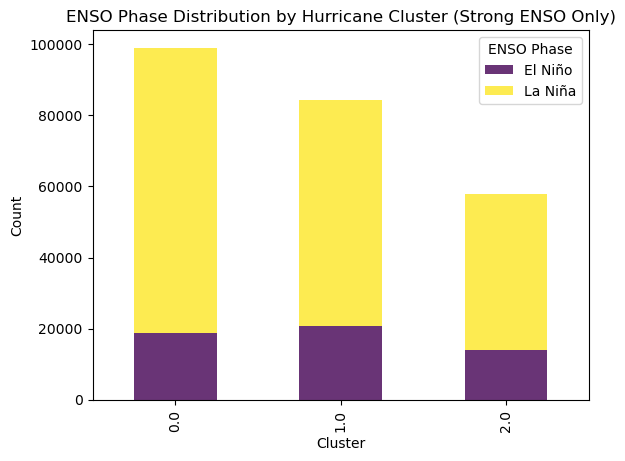

In [23]:
# Filter only years with strong La Niña (SOI ≥ 1.5) or strong El Niño (SOI ≤ -1.5)
enso_strong = storm_data[(storm_data["SOI_Hurricane_Season"] >= 1.5) | (storm_data["SOI_Hurricane_Season"] <= -1.5)]

# Group by cluster and ENSO phase
enso_strong_counts = enso_strong.groupby("Cluster")["ENSO_Phase"].value_counts().unstack()

# Plot ENSO phase distribution by cluster for strong ENSO years
plt.figure(figsize=(8, 5))
enso_strong_counts.plot(kind="bar", stacked=True, colormap="viridis", alpha=0.8)
plt.title("ENSO Phase Distribution by Hurricane Cluster (Strong ENSO Only)")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="ENSO Phase")
plt.show()

"Comparison with the Previous Graph"

In the earlier graph (which included all ENSO conditions), Neutral ENSO dominated.

However, when filtering only for strong ENSO years:
Hurricanes during La Niña remain significantly more frequent than during El Niño.

The spatial clustering pattern does not drastically change—all three clusters maintain similar distributions.

Even in strong El Niño years, the number of hurricanes is much lower than in strong La Niña years.

### 10. Final Interpretation

### 11. Futher  examination

Analyzing Hurricane Intensity During ENSO Phases

Index(['storm', 'date_time', 'quadrant', 'numobs', 'sid', 'season', 'number',
       'basin', 'subbasin', 'name',
       ...
       'storm_dir', 'Cluster', 'Year', 'SOI_Annual_x',
       'SOI_Hurricane_Season_x', 'SOI_Annual_y', 'SOI_Hurricane_Season_y',
       'SOI_Annual', 'SOI_Hurricane_Season', 'ENSO_Phase'],
      dtype='object', length=162)


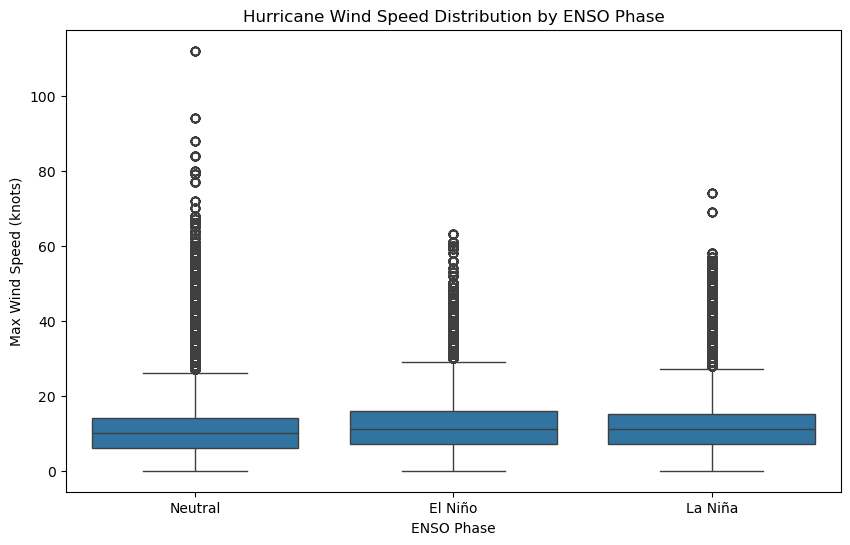

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Check available columns
print(storm_data.columns)  # Debugging step

# Extract relevant columns for analysis
enso_intensity_data = storm_data[["Year", "lat", "lon", "storm_speed", "ENSO_Phase"]].dropna()

## **Hurricane Wind Speed vs. ENSO Phase**
plt.figure(figsize=(10, 6))
sns.boxplot(data=enso_intensity_data, x="ENSO_Phase", y="storm_speed")
plt.title("Hurricane Wind Speed Distribution by ENSO Phase")
plt.xlabel("ENSO Phase")
plt.ylabel("Max Wind Speed (knots)")
plt.show()